This notebook was prepared by <a href="https://montangerp.github.io/" target="_blank"> Patricia Montanger</a>. Source and license info is on <a href="https://github.com/montangerp" target="_blank">GitHub</a>. <br>
This research made use of <a href="https://docs.lightkurve.org/index.html" target="_blank">Lightkurve</a>, a Python package for Kepler and TESS data analysis (Lightkurve Collaboration, 2018).

# Manipulação de dados 

## Descrição

Neste notebook é realizado o processo de limpeza, reestruturação e reformatação de dados, mais especificamente de séries temporais, para que fiquem em um formato adequado para análise.

Os dados utilizados são curvas de luz provenientes de milhares de estrelas e adquiridas através do telescópio **Kepler**, onde cada ponto da curva representa a magnitude da estrela em função do tempo. Queremos obter uma quantidade significativa de curvas, para posteriormente realizar pesquisas para encontrar padrões nas séries temporais e utiliza-las em algoritmos de machine learning, auxiliando assim os astronômos na identificação de exoplanetas.
    
<img src="imagens/esolc.jpg" style="width:500px;height:400px"/>

<div style="text-align: center"><a href="https://www.eso.org/public/images/eso1023f/" target="_blank"> Fonte </a>       </div>

A fonte de dados utilizada foi o <a href="https://exoplanetarchive.ipac.caltech.edu/" target="_blank">NASA Exoplanet Archive</a>, um catálogo online que coleta e correlaciona dados e informações astronômicas sobre exoplanetas e suas estrelas hospedeiras, além de fornecer ferramentas para trabalhar com esses dados. Esses dados incluem parâmetros estelares como posições, magnitudes, temperaturas e parâmetros de exoplanetas como massas, parâmetros orbitais e dados de descoberta e caracterização como curvas de velocidade radial, curvas de luz fotométricas, imagens e espectros.

## Objetivo

Nosso objetivo é importar e manipular dados do Kepler para posteriormente aplicar em algoritmos de machine learning.

- Primeiro passo: através da página de arquivos do kepler importamos os nomes dos objetos (Kepler ID), suas respectivas classes e quarters.

- Segundo passo: importar os dados para o Jupyter e explorar os dados.

- Terceiro passo: selecionar apenas as classes de interesse.

- Quarto passo: remover valores ausentes.

- Quinto passo: selecionar curvas de acordo com o quarter desejado pelo usuário.

- Sexto passo: com a biblioteca Lightcurve fazer o download do fluxo das curvas de luz.

- Sétimo passo: remover valores ausentes.

- Oitavo passo: adicionar as classes para os fluxos importados.

- Nono passo: salvar arquivos csv.

- Décimo passo: visualizar resultado final.

### Primeiro passo

Na página do NASA Exoplanet Archive selecionamos apenas as colunas de dados de interesse e realizamos o download do arquivo CSV contendo os parâmetros:
>**KepID<br>
Exoplanet Archive Disposition<br>
Quarters**




<img src="imagens/exoarchive.png"  style="width:800px;height:400px"/>

<div style="text-align: center"><a href="https://exoplanetarchive.ipac.caltech.edu/" target="_blank"> Fonte </a>       </div>

### Segundo passo

In [1]:
import pandas as pd
import numpy as np
import time
import csv
import matplotlib.pyplot as plt
from lightkurve import search_lightcurvefile

Utilizaremos a biblitoeca Lightkurve que nos auxiliará quando desejarmos importar as curvas luz, está biblioteca oferece uma maneira fácil de analisar dados de séries temporais obtidos por telescópios, em particular as das missões Kepler e TESS da NASA.

In [2]:
lc = pd.read_csv("kepler_data_quarter.csv", sep = ",") 
lc.head()

,kepid,koi_disposition,koi_quarters
0,10797460,CONFIRMED,11111111111111111000000000000000
1,10797460,CONFIRMED,11111111111111111000000000000000
2,10811496,CANDIDATE,11111101110111011000000000000000
3,10848459,FALSE POSITIVE,11111110111011101000000000000000
4,10854555,CONFIRMED,01111111111111111000000000000000


In [3]:
lc.tail()

,kepid,koi_disposition,koi_quarters
9559,10090151,FALSE POSITIVE,11111101110111011000000000000000
9560,10128825,CANDIDATE,11111111111111111000000000000000
9561,10147276,FALSE POSITIVE,11111111111111111000000000000000
9562,10155286,CANDIDATE,11111101110111011000000000000000
9563,10156110,FALSE POSITIVE,11111101110111011000000000000000


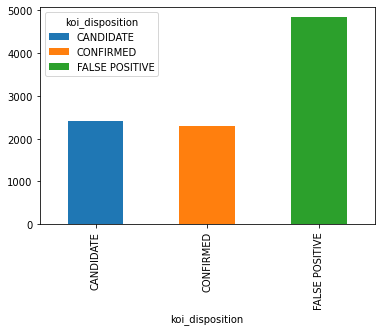

In [4]:
# comparação da quantidade de objetos por classe
lc.groupby(['koi_disposition','koi_disposition']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

In [5]:
lc.dtypes

kepid               int64
koi_disposition    object
koi_quarters       object
dtype: object

In [6]:
lc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   kepid            9564 non-null   int64 
 1   koi_disposition  9564 non-null   object
 2   koi_quarters     8422 non-null   object
dtypes: int64(1), object(2)
memory usage: 224.3+ KB


Observe que temos 3 classes: 
>**Falsos positivos<br>Candidatos<br>Confirmados** <br>

Porém queremos apenas os falsos positivos e confirmados de forma que vamos iniciar retirando todos os itens classificados como candidatos.
Além disso visualizamos acima que em koi_quarters existem valores ausentes, os quais precisarão ser removidos ou substituídos.

### Terceiro passo

In [7]:
lc_array = np.array(lc)
print('total inicial de curvas: %d'%(len(lc_array)))

total inicial de curvas: 9564


In [8]:
# retira os labels 'candidate' da base de dados: nova base lc_array_wc 
lc_array_wc = []
for i in range(0, len(lc_array)):
    if lc_array[i][1] == 'CANDIDATE':
        np.delete(lc_array, i, 0)
    else:
        lc_array_wc.append(lc_array[i])
        
# quantidade de itens em cada classe 
confirmed = []
false_positive = []
for i in range(0, len(lc_array_wc)):
    if lc_array_wc[i][1] == 'CONFIRMED':
        confirmed.append(lc_array_wc[i])
    else:
        false_positive.append(lc_array_wc[i])

print('falsos positivos: %d, confirmados: %d\n\ntotal atualizado: %d'%(len(false_positive),len(confirmed), len(false_positive)+len(confirmed)))

falsos positivos: 4841, confirmados: 2303

total atualizado: 7144


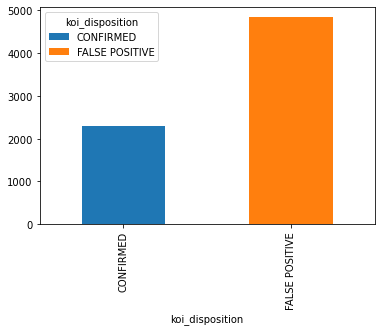

In [9]:
# comparação da quantidade de objetos por classe
df = pd.DataFrame(data=lc_array_wc, columns=["kepid", "koi_disposition", "koi_quarters"])
df.groupby(['koi_disposition','koi_disposition']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

### Quarto passo

Temos agora nossos dados apenas com os labels de interesse e vamos excluír os valores ausentes existentes na coluna quarters.

In [10]:
# exclui as curvas com valores ausentes da coluna 'quarters'
lc_array_wc_wn = []
for i in range(0, len(lc_array_wc)):
    h = lc_array_wc[i][2]
    if pd.isnull(h) == True:
        np.delete(lc_array_wc, i, 0)
    else:
        lc_array_wc_wn.append(lc_array_wc[i])
        
print('total atualizado: %d'%(len(lc_array_wc_wn)))

total atualizado: 6465


### Quinto passo

Neste passo temos que entender que para usar a biblioteca Lightkurve precisamos selecionar o quarter (ou trimestre) que desejamos que nossa base de curvas de luz possua. Os trimestres variam entre 1 e 17 e são representados de forma binária:

  kepid | koi_disposition|          koi_quarters
--------|----------------| --------------------------------
10797460|   CONFIRMED    | 11111111111111111000000000000000
10811496|   CONFIRMED    | 11111101110111011000000000000000
10848459| FALSE POSITIVE | 11111110111011101000000000000000

O **número 1** nos diz que existe uma curva de luz dísponivel para aquele quarter, já o **número 0** nos diz que não há uma curva para aquele quarter. Sabendo disso, temos que selecionar o quarter desejado antes de importar as curvas.

In [11]:
quarter = 1           # alterar aqui de acordo com o valor de quarter desejado entre 1 e 17  

In [12]:
# seleciona apenas as curvas com o quarter escolhido
lc_array_wc_wn_Q = []
for i in range(0, len(lc_array_wc_wn)):
    if len(lc_array_wc_wn[i][2]) != 32 and len(lc_array_wc_wn[i][2]) != (32 - quarter + 1):
        np.delete(lc_array_wc_wn, i, 0)
    else:
        lc_array_wc_wn_Q.append(lc_array_wc_wn[i]) 
lc_array_wc_wn_Q_sq = []                               
for i in range(0, len(lc_array_wc_wn_Q)):
    if len(lc_array_wc_wn_Q[i][2]) == 32 and lc_array_wc_wn_Q[i][2][quarter-1] == '0':
        np.delete(lc_array_wc_wn_Q, i, 0)
    elif len(lc_array_wc_wn_Q[i][2]) == (32 - quarter + 1) and lc_array_wc_wn_Q[i][2][0] == '0':
        np.delete(lc_array_wc_wn_Q, i, 0)
    else:
        lc_array_wc_wn_Q_sq.append(lc_array_wc_wn_Q[i]) 

print('Quarter = %d \n\nTotal atualizado: %d'%((quarter),len(lc_array_wc_wn_Q_sq)))

Quarter = 1 

Total atualizado: 5297


Na nova lista estão apenas as curvas que possuem o **quarter = 1**, portanto temos agora um número atualizado no total de curvas.

In [13]:
# quantidade de itens e porcentagem em cada classe para o quarter selecionado
confirmed_ = []
false_positive_ = []
for i in range(0, len(lc_array_wc_wn_Q_sq)):
    if lc_array_wc_wn_Q[i][1] == 'CONFIRMED':
        confirmed_.append(lc_array_wc_wn_Q_sq[i])
    else:
        false_positive_.append(lc_array_wc_wn_Q_sq[i])

total_lc = len(lc_array_wc_wn_Q_sq)
porcent_fp = (100*len(false_positive_))/total_lc
porcent_c = (100*len(confirmed_))/total_lc 

print('falsos positivos: %d \t\t %f porcento \nconfirmados: %d \t\t %f porcento \n\ntotal atualizado: %d'%(len(false_positive_),porcent_fp,len(confirmed_),porcent_c,len(false_positive_)+len(confirmed_)))

falsos positivos: 3007 		 56.767982 porcento 
confirmados: 2290 		 43.232018 porcento 

total atualizado: 5297


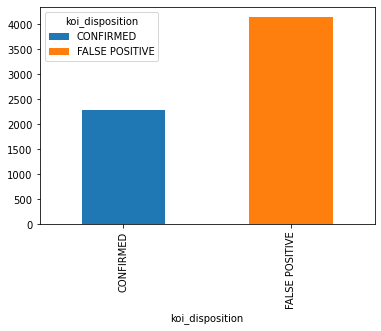

In [14]:
# comparação da quantidade de objetos por classe
dfq = pd.DataFrame(data=lc_array_wc_wn_Q, columns=["kepid", "koi_disposition", "koi_quarters"])
dfq.groupby(['koi_disposition','koi_disposition']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

### Sexto passo

Agora vamos importar as curvas através do Lightcurve, neste exemplo importamos apenas algumas das curvas disponíveis, é possível importar todas porém é um processo que levaria horas e exigiria muito de um computador comum, **é recomendável utilizar um GPU/Cluster para executar esta etapa** caso queira trabalhar com todas as curvas.

In [15]:
# importando as curvas de luz com o KeplerGO
lc_flux = []
start_time = time.time()
for i in range(0,10):                                           # durante testes altere a quantidade de curvas aqui
#for i in range(0, len(lc_array_wc_wn_Q_sq)):                   # descomente esta linha para importar todas as curvas
    ep = str(lc_array_wc_wn_Q_sq[i][0])                                                     # seleciona os KeplerID
    lcf = search_lightcurvefile(ep, quarter = quarter).download()         
    lcf = lcf.PDCSAP_FLUX                                             
    lc_flux.append(lcf.flux)
t = time.time() - start_time   

print('\nTempo para importar curvas de luz: %f seconds\n' %t)

gzip was not found on your system! You should solve this issue for astroquery.eso to be at its best!
On POSIX system: make sure gzip is installed and in your path!On Windows: same for 7-zip (http://www.7-zip.org)!

Tempo para importar curvas de luz: 17.964212 seconds



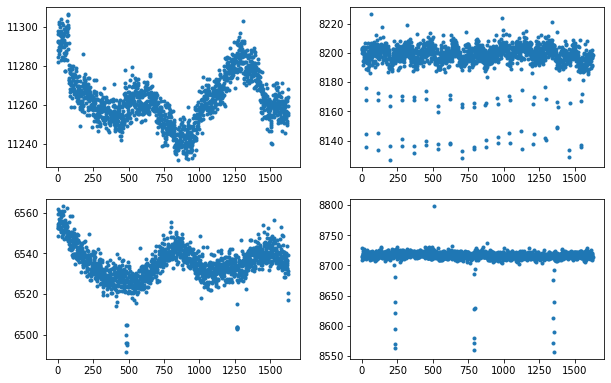

In [16]:
# visualização das curvas importadas
fig = plt.figure(figsize=(10, 10)) 
fig_dims = (3, 2)
dflux = pd.DataFrame(data=lc_flux)
plt.subplot2grid(fig_dims, (0, 0)),plt.plot(dflux.iloc[0],'.')
plt.subplot2grid(fig_dims, (0, 1)),plt.plot(dflux.iloc[2],'.')
plt.subplot2grid(fig_dims, (1, 0)),plt.plot(dflux.iloc[4],'.')
plt.subplot2grid(fig_dims, (1, 1)),plt.plot(dflux.iloc[9],'.')
plt.show()

Já com as curvas na lista *lc_flux* vamos verificar se todas as curvas importadas possuem o mesmo tamanho e apresentar uma mensagem caso alguma tenha um tamanho diferente, raramente existem curvas de tamanhos diferentes para o mesmo quarter, porém sempre realizaremos esta verificação. 

In [17]:
# verificar se todas as curvas importadas possuem o mesmo tamanho
for i in range(0,len(lc_flux)):
    if len(lc_flux[i]) != len(lc_flux[i-1]):
        print("A curva %d possui tamanho diferente das demais curvas. Tamanho: %d "%(i,len(lc_flux[i])))
print("Caso nenhuma das curvas apresente tamanho diferente, todas as curvas possuem o total de %d pontos cada.\n"%len(lc_flux[3]))

Caso nenhuma das curvas apresente tamanho diferente, todas as curvas possuem o total de 1626 pontos cada.



### Sétimo passo

Assim como na tabela inicial existiam valores ausentes, nas curvas recém importadas também existem pontos ausentes então vamos identificar estes pontos a seguir e guardar seus indices para verificar a procentagem de pontos que precisaram ser substituídos e assim garantir que não sejam suficientes grandes para alterar as análises feitas no futuro utilizando esta base de dados. Esses dados serão salvos em uma tabela CSV caso seja necessário identificá-los em trabalhos futuros.

In [18]:
# percorre todos os pontos de todas as curvas verificando onde existem NaN, guarda os indices e quantidades
count = 0
notanumber = []
notanumber.append(('Ponto da curva','Curva'))
for j in range(0, len(lc_flux)):
    for i in range(0,len(lc_flux[j])):
        h = lc_flux[j][i]
        if pd.isnull(h) == True:
            notanumber.append((i,j))
            count+=1
 
# salva tabela csv com curvas e pontos contendo nan 
csvfile_nan = "nan_Q1.csv"
with open(csvfile_nan, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(notanumber)
            
print("Total de pontos com valores ausentes: %d\n" %count)

Total de pontos com valores ausentes: 20



Para lidar com os valores ausentes escolhemos uma função que os substitui automaticamente por zero.

In [19]:
# porcentagem de dados que serão subsituidos por zero 
total = len(lc_flux)*len(lc_flux[0])
porcent = (100*count)/total

print("Porcentagem de valores ausentes substituídos por zero: %f porcento\n" %porcent)

# funçao que substitui NaN por zero e Inf por números finitos
lc_flux_ = np.nan_to_num(lc_flux)

Porcentagem de valores ausentes substituídos por zero: 0.123001 porcento



Observamos que a porcentagem de valores ausentes não é grande o suficiente para interferir nas análises, então vamos para a próxima etapa.

### Oitavo passo

Vamos adicionar as classes correspondentes as curvas que importamos.

In [20]:
# aqui adicionamos os labels ao lc_flux (curvas de luz) 
# labels estão no lc_array_wc_wn_Q1_sq
selected_list = []
for i in range(0,len(lc_flux_)):
    selected_list.append(lc_flux_[i].tolist())
    selected_list[i].append(lc_array_wc_wn_Q_sq[i][1])

selected_list = list(map(list, zip(*selected_list)))

label = "Label"
selected_list [len(lc_flux_[3])].insert(0,label)     

flux = "Flux"
for i in range(0,len(lc_flux_[3])):
    selected_list[i].insert(0,flux)
    
selected_list = list(map(list, zip(*selected_list)))

Se houver valores ausentes restantes na base de dados, nossa análise será prejudicada, então por redundância vamos realizar a verificação novamente.

In [21]:
# redundância para verificar se existem NaN
# Obs.: deve sempre ser zero
count_ = 0
notanumber_ = []
notanumber_.append(('Ponto da curva','Curva'))
for j in range(0, len(selected_list)):
    for i in range(0,len(selected_list[j])):
        h = selected_list[j][i]
        if pd.isnull(h) == True:
            notanumber_.append((i,j))
            count_+=1

print("Total de pontos contendo valores ausentes (segunda verificação): %d  ----> deve sempre ser zero" %count_)

Total de pontos contendo valores ausentes (segunda verificação): 0  ----> deve sempre ser zero


### Nono passo

Finalmente temos a base de dados pronta para análise e podemos salvá-la em um arquivo CSV.

In [22]:
# salvando tabela final em formato csv. já com quarter, labels e fluxo definidos
csvfile = "dados_Q1.csv"
with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerows(selected_list)

### Décimo passo

In [23]:
pd.read_csv("dados_Q1.csv", sep = ",").head()

,Flux,Flux.1,Flux.2,Flux.3,Flux.4,Flux.5,Flux.6,Flux.7,Flux.8,Flux.9,...,Flux.1617,Flux.1618,Flux.1619,Flux.1620,Flux.1621,Flux.1622,Flux.1623,Flux.1624,Flux.1625,Label
0,11288.066406,11292.760742,11281.872070,11298.019531,11284.711914,11292.368164,11296.479492,11288.382812,11288.015625,11302.500977,...,11262.921875,11250.892578,11251.499023,11249.472656,11255.666016,11259.477539,11254.582031,11268.262695,11263.854492,CONFIRMED
1,11288.066406,11292.760742,11281.872070,11298.019531,11284.711914,11292.368164,11296.479492,11288.382812,11288.015625,11302.500977,...,11262.921875,11250.892578,11251.499023,11249.472656,11255.666016,11259.477539,11254.582031,11268.262695,11263.854492,CONFIRMED
2,8199.683594,8203.690430,8201.837891,8202.610352,8200.041016,8194.414062,8203.027344,8203.117188,8204.064453,8191.709473,...,8198.636719,8190.932129,8196.329102,8201.858398,8191.613281,8196.993164,8197.906250,8199.167969,8198.675781,FALSE POSITIVE
3,124407.843750,124410.914062,124413.546875,124393.281250,124406.789062,124403.601562,124421.164062,124411.929688,124396.515625,124418.281250,...,124415.921875,124399.828125,124420.140625,124417.203125,124409.242188,124407.023438,124386.234375,124405.234375,124400.570312,FALSE POSITIVE
4,6559.518555,6552.599609,6548.751953,6554.393066,6552.321289,6561.672852,6553.577637,6556.897461,6554.946289,6552.674316,...,6535.249023,6532.930176,6536.879883,6532.363281,6539.292480,6529.866211,6531.430176,6520.676270,6516.936035,CONFIRMED


In [24]:
pd.read_csv("nan_Q1.csv", sep = ",").head()

,Ponto da curva,Curva
0,979,0
1,1167,0
2,979,1
3,1167,1
4,979,2
